In [47]:
from os.path import basename, exists

def download(url):
    filename = basename(url)
    if not exists(filename):
        from urllib.request import urlretrieve
        local, _ = urlretrieve(url, filename)
        print('Downloaded ' + local)
    
download('https://github.com/AllenDowney/ModSimPy/raw/master/' +
         'modsim.py')
from modsim import *
download('https://github.com/AllenDowney/ModSimPy/raw/master/chap11.py')
from chap11 import make_system
from chap11 import update_func
from chap11 import run_simulation

In [48]:
def make_system(beta, gamma):
    """Make a system object for the SIR model.
    
    beta: contact rate in days
    gamma: recovery rate in days
    
    returns: System object
    """
    init = State(S=89, I=1, R=0)
    init /= sum(init)

    t0 = 0
    t_end = 7 * 14

    return System(init=init, t0=t0, t_end=t_end,
                  beta=beta, gamma=gamma)

In [49]:
def update_func(state, t, system):
    """Update the SIR model.
    
    state: State with variables S, I, R
    t: time step
    system: System with beta and gamma
    
    returns: State object
    """
    s, i, r = state

    infected = system.beta * i * s    
    recovered = system.gamma * i
    
    s -= infected
    i += infected - recovered
    r += recovered
    
    return State(S=s, I=i, R=r)

In [50]:
def run_simulation(system, update_func):
    """Runs a simulation of the system.
        
    system: System object
    update_func: function that updates state
    
    returns: TimeFrame
    """
    frame = TimeFrame(columns=system.init.index)
    frame.loc[system.t0] = system.init
    
    for t in linrange(system.t0, system.t_end):
        frame.loc[t+1] = update_func(frame.loc[t], t, system)
    
    return frame

In [51]:
def calc_total_infected(results):
    s_0 = results.S[0]
    s_end = results.S[system.t_end]
    return s_0 - s_end

In [52]:
beta = 0.333
gamma = 0.25
system = make_system(beta, gamma)

results = run_simulation(system, update_func)
print(beta, gamma, calc_total_infected(results))

0.333 0.25 0.46716293183605073


In [53]:
#Exercise1: Write functions that take a TimeFrame object as a parameter and compute the other metrics mentioned in the book:

# The fraction of students who are sick at the peak of the outbreak.

def fraction_sickatpeak(results):
    return results.I.max()

fraction_sickatpeak(results)

0.043536202687592354

In [54]:
# The day the outbreak peaks

def day_peak(results):
    return results.I.idxmax()

day_peak(results)

30.0

In [55]:
# The fraction of students who are sick at the end of the semester.

def sick_at_end(results):
    return results.I[0]

sick_at_end(results)

0.011111111111111112

In [56]:
#what if 
def add_immunization(system, fraction):
    """Immunize a fraction of the population.
    
    Moves the given fraction from S to R.
    
    system: System object
    fraction: number from 0 to 1
    """
    system.init.S -= fraction
    system.init.R += fraction

In [57]:
tc = 3      # time between contacts in days 
tr = 4      # recovery time in days

beta = 1 / tc      # contact rate in per day
gamma = 1 / tr     # recovery rate in per day

system = make_system(beta, gamma)

In [58]:
results = run_simulation(system, update_func)
calc_total_infected(results)

0.468320811028781

In [59]:
system2 = make_system(beta, gamma)
add_immunization(system2, 0.1)
results2 = run_simulation(system2, update_func)
calc_total_infected(results2)

0.30650802853979753

FileNotFoundError: [Errno 2] No such file or directory: 'figs/chap12-fig01.pdf'

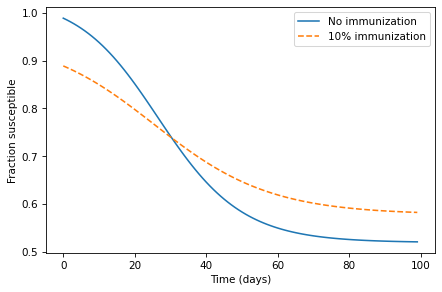

In [60]:
from matplotlib.pyplot import *

plot(results.S, '-', label='No immunization')
plot(results2.S, '--', label='10% immunization')

decorate(xlabel='Time (days)',
         ylabel='Fraction susceptible')

savefig('figs/chap12-fig01.pdf')

In [61]:
immunize_array = linspace(0, 1, 11)
for fraction in immunize_array:
    system = make_system(beta, gamma)
    add_immunization(system, fraction)
    results = run_simulation(system, update_func)
    print(fraction, calc_total_infected(results))

0.0 0.468320811028781
0.1 0.30650802853979753
0.2 0.16136545700638427
0.30000000000000004 0.0728155898425179
0.4 0.03552021675299155
0.5 0.019688715782459176
0.6000000000000001 0.011622057998337987
0.7000000000000001 0.006838737800619332
0.8 0.003696496253713877
0.9 0.0014815326722661948
1.0 -0.00016121210941239666


In [62]:
def sweep_immunity(immunize_array):
    """Sweeps a range of values for immunity.
    
    immunize_array: array of fraction immunized
    
    returns: Sweep object
    """
    sweep = SweepSeries()
    
    for fraction in immunize_array:
        system = make_system(beta, gamma)
        add_immunization(system, fraction)
        results = run_simulation(system, update_func)
        sweep[fraction] = calc_total_infected(results)
        
    return sweep

In [63]:
immunize_array = linspace(0, 1, 21)
infected_sweep = sweep_immunity(immunize_array)

AttributeError: Axes.set() got an unexpected keyword argument 'legend'

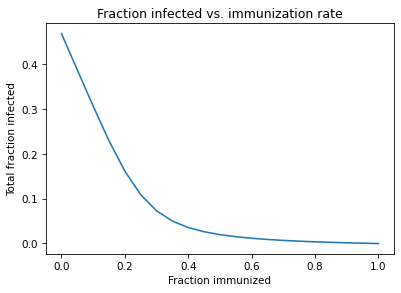

In [64]:
plot(infected_sweep)

decorate(xlabel='Fraction immunized',
         ylabel='Total fraction infected',
         title='Fraction infected vs. immunization rate',
         legend=False)

savefig('figs/chap12-fig02.pdf')

In [65]:
import math
import numpy as np
def logistic(x, A=0, B=1, C=1, M=0, K=1, Q=1, nu=1):
    """Computes the generalize logistic function.
    
    A: controls the lower bound
    B: controls the steepness of the transition 
    C: not all that useful, AFAIK
    M: controls the location of the transition
    K: controls the upper bound
    Q: shift the transition left or right
    nu: affects the symmetry of the transition
    
    returns: float or array
    """
    exponent = -B * (x - M)
    denom = C + Q *(2.718**exponent)
    return A + (K-A) / denom ** (1/nu)

In [66]:
spending = linspace(0, 1200, 21)

In [67]:
def compute_factor(spending):
    """Reduction factor as a function of spending.
    
    spending: dollars from 0 to 1200
    
    returns: fractional reduction in beta
    """
    return logistic(spending, M=500, K=0.2, B=0.01)

AttributeError: Axes.set() got an unexpected keyword argument 'legend'

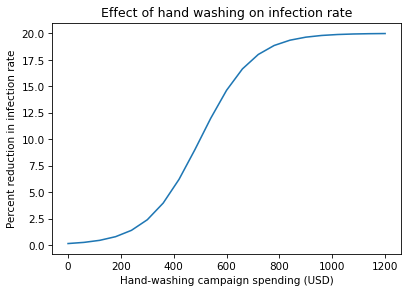

In [68]:
percent_reduction = compute_factor(spending) * 100

plot(spending, percent_reduction)

decorate(xlabel='Hand-washing campaign spending (USD)',
         ylabel='Percent reduction in infection rate',
         title='Effect of hand washing on infection rate',
         legend=False)


AttributeError: Axes.set() got an unexpected keyword argument 'legend'

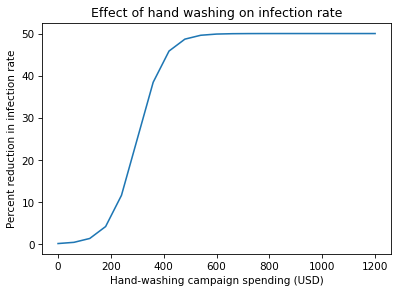

In [69]:
#Exercise: Modify the parameters M, K, and B, and see what effect they have on the shape of the curve
spending = linspace(0, 1200, 21)
#modify m to 300, K to 0.5, B to 0.02
def compute_factor(spending):
    """Reduction factor as a function of spending.
    
    spending: dollars from 0 to 1200
    
    returns: fractional reduction in beta
    """
    return logistic(spending, M=300, K=0.5, B=0.02)

percent_reduction = compute_factor(spending) * 100

plot(spending, percent_reduction)

decorate(xlabel='Hand-washing campaign spending (USD)',
         ylabel='Percent reduction in infection rate',
         title='Effect of hand washing on infection rate',
         legend=False)
#Results in a much steeper curve


In [70]:
#Hand washing:
def add_hand_washing(system, spending):
    """Modifies system to model the effect of hand washing.
    
    system: System object
    spending: campaign spending in USD
    """
    factor = compute_factor(spending)
    system.beta *= (1 - factor)

In [71]:
tc = 3      # time between contacts in days 
tr = 4      # recovery time in days

beta = 1 / tc      # contact rate in per day
gamma = 1 / tr     # recovery rate in per day

beta, gamma

(0.3333333333333333, 0.25)

In [72]:
spending_array = linspace(0, 1200, 13)

for spending in spending_array:
    system = make_system(beta, gamma)
    add_hand_washing(system, spending)
    results = run_simulation(system, update_func)
    print(spending, system.beta, calc_total_infected(results))

0.0 0.3329209736565053 0.46688798473533977
100.0 0.3303344105323396 0.4577954157982903
200.0 0.313462550648638 0.3938548817670898
300.0 0.25 0.12550437089833055
400.0 0.186537449351362 0.029589315969294372
500.0 0.16966558946766042 0.02195167867515213
600.0 0.16707902634349464 0.021014477432166
700.0 0.16672260471945588 0.020889278225733943
800.0 0.16667424082690369 0.020872361049085075
900.0 0.16666769197066067 0.020870071636193477
1000.0 0.16666680545598872 0.02086976174372157
1100.0 0.16666668545366783 0.020869719795824082
1200.0 0.16666666920973833 0.02086971411761951


In [73]:
def sweep_hand_washing(spending_array):
    """Run simulations with a range of spending.
    
    spending_array: array of dollars from 0 to 1200
    
    returns: Sweep object
    """
    sweep = SweepSeries()
    
    for spending in spending_array:
        system = make_system(beta, gamma)
        add_hand_washing(system, spending)
        results = run_simulation(system, update_func)
        sweep[spending] = calc_total_infected(results)
        
    return sweep

In [74]:
spending_array = linspace(0, 1200, 20)
infected_sweep = sweep_hand_washing(spending_array)

AttributeError: Axes.set() got an unexpected keyword argument 'legend'

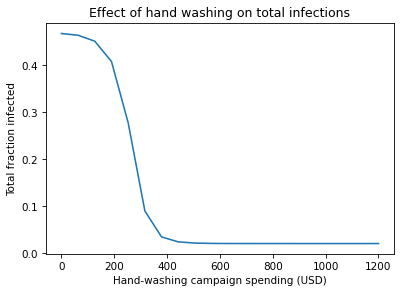

In [75]:
plot(infected_sweep)

decorate(xlabel='Hand-washing campaign spending (USD)',
         ylabel='Total fraction infected',
         title='Effect of hand washing on total infections',
         legend=False)

savefig('figs/chap12-fig03.pdf')

In [ ]:
#Optimization
num_students = 90
budget = 1200
price_per_dose = 100
max_doses = int(budget / price_per_dose)
dose_array = linrange(max_doses)
max_doses

In [76]:
for doses in dose_array:
    fraction = doses / num_students
    spending = budget - doses * price_per_dose
    
    system = make_system(beta, gamma)
    add_immunization(system, fraction)
    add_hand_washing(system, spending)
    
    results = run_simulation(system, update_func)
    print(doses, system.init.S, system.beta, calc_total_infected(results))

NameError: name 'dose_array' is not defined

In [77]:
def sweep_doses(dose_array):
    """Runs simulations with different doses and campaign spending.
    
    dose_array: range of values for number of vaccinations
    
    return: Sweep object with total number of infections 
    """
    sweep = SweepSeries()
    
    for doses in dose_array:
        fraction = doses / num_students
        spending = budget - doses * price_per_dose
        
        system = make_system(beta, gamma)
        add_immunization(system, fraction)
        add_hand_washing(system, spending)
        
        results = run_simulation(system, update_func)
        sweep[doses] = calc_total_infected(results)

    return sweep

In [78]:
infected_sweep = sweep_doses(dose_array)

NameError: name 'dose_array' is not defined

AttributeError: Axes.set() got an unexpected keyword argument 'legend'

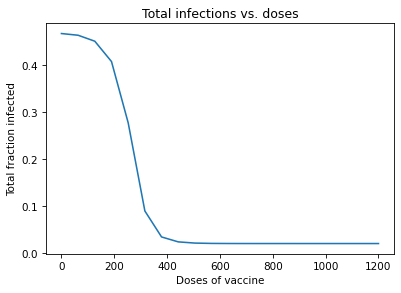

In [79]:
plot(infected_sweep)

decorate(xlabel='Doses of vaccine',
         ylabel='Total fraction infected',
         title='Total infections vs. doses',
         legend=False)

savefig('figs/chap12-fig04.pdf')

0.0 0.9888888888888889 0.16666666920973833 0.02086971411761951
1.0 0.9777777777777779 0.16666667357873527 0.02022138652727412
2.0 0.9666666666666667 0.16666668545366783 0.0195980523165995
3.0 0.9555555555555556 0.1666667177297259 0.018998345223318003
4.0 0.9444444444444445 0.16666680545598872 0.018420998851570225
5.0 0.9333333333333333 0.16666704389550438 0.017864848108929965
6.0 0.9222222222222223 0.16666769197066067 0.017328845605683707
7.0 0.9111111111111112 0.16666945341346975 0.0168121157722233
8.0 0.9 0.16667424082690369 0.016314105893134867
9.0 0.888888888888889 0.1666872516270316 0.015834987959774893
10.0 0.8777777777777778 0.16672260471945588 0.015376711536300935
11.0 0.8666666666666667 0.1668186186771829 0.014945749163430166
12.0 0.8555555555555556 0.16707902634349464 0.014560249764628108
13.0 0.8444444444444446 0.16778271638339862 0.014268705201881171
14.0 0.8333333333333334 0.16966558946766042 0.014198847802659675
15.0 0.8222222222222223 0.17457332124717306 0.01468662821888

AttributeError: Axes.set() got an unexpected keyword argument 'legend'

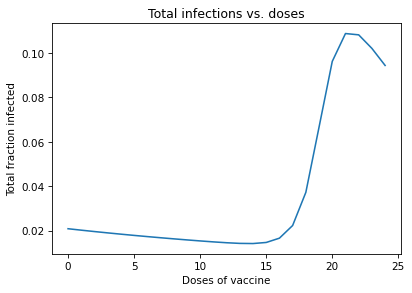

In [80]:
#Exercise: Suppose the price of the vaccine drops to $50 per dose.
num_students = 90
budget = 1200
price_per_dose = 50
max_doses = int(budget / price_per_dose)
dose_array = linrange(max_doses)
max_doses

for doses in dose_array:
    fraction = doses / num_students
    spending = budget - doses * price_per_dose
    
    system = make_system(beta, gamma)
    add_immunization(system, fraction)
    add_hand_washing(system, spending)
    
    results = run_simulation(system, update_func)
    print(doses, system.init.S, system.beta, calc_total_infected(results))
    
def sweep_doses(dose_array):
    """Runs simulations with different doses and campaign spending.
    
    dose_array: range of values for number of vaccinations
    
    return: Sweep object with total number of infections 
    """
    sweep = SweepSeries()
    
    for doses in dose_array:
        fraction = doses / num_students
        spending = budget - doses * price_per_dose
        
        system = make_system(beta, gamma)
        add_immunization(system, fraction)
        add_hand_washing(system, spending)
        
        results = run_simulation(system, update_func)
        sweep[doses] = calc_total_infected(results)

    return sweep

infected_sweep = sweep_doses(dose_array)

plot(infected_sweep)

decorate(xlabel='Doses of vaccine',
         ylabel='Total fraction infected',
         title='Total infections vs. doses',
         legend=False)

In [ ]:
#Exercise: Suppose we have the option to quarantine infected students.
def add_quarantine(system, fraction):  ##Model the effect of quarantine by adjusting gamma.
    low = 1
    high = 4
    tr = high - fraction * (high-low)
    system.gamma = 1 / tr